### Demo: train/tune the model and save to Model Catalog

* In this Notebook we will see how to train a sklearn pipeline and save the model to the Model Catalog.
* We will show how to add metadata (reference dataset, metrics..)
* How to deploy the model as a REST service
* Tuning of HP with **ADSTuner**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import tempfile

import ads
from ads import set_auth

# ADS tuner
from ads.hpo.distributions import *
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *

# to save to Model Catalog
from ads.catalog.model import ModelCatalog
from ads.common.model_metadata import UseCaseType, MetadataCustomCategory
from ads.model.framework.sklearn_model import SklearnModel


import lightgbm as lgb

from sklearn.metrics import classification_report
from sklearn.metrics import get_scorer, make_scorer, f1_score, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# added to handle with pipelines
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from ads.dataset.factory import DatasetFactory

import logging
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

%matplotlib inline

In [2]:
# we need ads 2.5.10 or greater
print(ads.__version__)

2.6.2


In [3]:
# set RP
set_auth(auth='resource_principal')

### Prima Parte: preparazione dati

* the dataset is upsampled, to address the imbalance

In [4]:
#
# definisco le funzioni che identificano le categorie di colonne
#
def cat_cols_selector(df, target_name):
    # the input is the dataframe
    
    # cols with less than THR values are considered categoricals
    THR = 10
    
    nunique = df.nunique()
    types = df.dtypes
    
    col_list = []
    
    for col in df.columns:
        if ((types[col] == 'object') or (nunique[col] < THR)):
            # print(col)
            if col != target_name:
                col_list.append(col)
    
    return col_list

def num_cols_selector(df, target_name):
    THR = 10
    
    types = df.dtypes
    nunique = df.nunique()
    
    col_list = []
    
    for col in df.columns:
        if (types[col] != 'object') and (nunique[col] >= THR): 
            # print(col)
            if col != target_name:
                col_list.append(col)
    
    return col_list

def load_as_dataframe(path):
    ds = DatasetFactory.open(path,
                             target="Attrition").set_positive_class('Yes')

    ds_up = ds.up_sample()

    # drop unneeded columns
    cols_to_drop = ['Directs','name', 'Over18','WeeklyWorkedHours','EmployeeNumber']

    ds_used = ds_up.drop(columns=cols_to_drop)
    
    df_used = ds_used.to_pandas_dataframe()
    
    

    # train, test split (lo faccio direttamente sui dataframe)
    df_train, df_test = train_test_split(df_used, shuffle=True, test_size=0.2, random_state = 1234)

    print("# of samples in train set", df_train.shape[0])
    print("# of samples in test set", df_test.shape[0])
    
    return df_train, df_test

In [5]:
# load the dataset and do upsampling
TARGET = 'Attrition'

attrition_path = "/opt/notebooks/ads-examples/oracle_data/orcl_attrition.csv"

# ritorna un dataset su cui è stato fatto l'upsampling
df_train, df_test = load_as_dataframe(attrition_path)

cat_cols = cat_cols_selector(df_train, TARGET)
num_cols = num_cols_selector(df_train, TARGET)

X_train, y_train = df_train.drop([TARGET], axis=1), df_train[TARGET]
X_test, y_test = df_test.drop([TARGET], axis=1), df_test[TARGET]

# prepare cat_cols for lightgbm
cat_cols_index = [i for i, x in enumerate(X_train.columns) if x in cat_cols]

print()
print(f'Numerical columns: {num_cols} ({len(num_cols)})')
print()
print(f'Categorical columns: {cat_cols} ({len(cat_cols)})')
print()
print("Indexes for cat_cols", cat_cols_index)

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

# of samples in train set 1972
# of samples in test set 494

Numerical columns: ['Age', 'SalaryLevel', 'CommuteLength', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'YearsinIndustry', 'YearsOnJob', 'YearsAtCurrentLevel', 'YearsSinceLastPromotion', 'YearsWithCurrManager'] (13)

Categorical columns: ['TravelForWork', 'JobFunction', 'EducationalLevel', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance'] (17)

Indexes for cat_cols [1, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 18, 20, 21, 22, 24, 25]


### Definisco la pipeline: trasformazioni + modello

In [6]:
#
# creo la parte Transformers per la pipeline Sklearn
#

# per questo dataset non vi sono missing values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('standard_scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

In [7]:
#
# definisco la pipeline completa
#
params = {
    # info
    # "verbose" : 0,
    "categorical_feature": cat_cols_index
}

pipe = Pipeline(steps=[('preprocessor', transformations),
                           ('clf', lgb.LGBMClassifier(**params))])

In [8]:
pipe.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('imputer', SimpleImputer()),
                                                   ('standard_scaler',
                                                    StandardScaler())]),
                                   ['Age', 'SalaryLevel', 'CommuteLength',
                                    'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
                                    'NumCompaniesWorked', 'PercentSalaryHike',
                                    'YearsinIndustry', 'YearsOnJob',
                                    'YearsAtCurrentLevel',
                                    'YearsSinceLastPromotion',
                                    'YearsWithCurrManager']),
                                  ('c...
                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                   unknown_value=-

### Tuning iper-parametri con ADS Tuner

In [37]:
scorer = make_scorer(accuracy_score)

In [38]:
tuner = ADSTuner(pipe, cv=3, n_jobs=2, scoring=scorer, random_state=42) ## cv is cross validation splits

tuner.tune(X_train, y_train, exit_criterion=[NTrials(40)])

In [60]:
tuner.status

<State.COMPLETED: 5>

In [56]:
print(f"Number of trials launched: {len(tuner.trials)}")

Number of trials launched: 40


In [59]:
tuner.trials.sort_values(by=["value"], ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_clf__colsample_bytree,params_clf__learning_rate,params_clf__max_depth,params_clf__n_estimators,params_clf__subsample,...,user_attrs_mean_score_time,user_attrs_mean_test_score,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
34,34,0.946755,2022-07-04 07:43:08.191127,2022-07-04 07:43:19.426708,0 days 00:00:11.235581,0.666281,0.395618,5,123,0.864386,...,0.020324,0.946755,accuracy_score,0.946809,0.943683,0.949772,0.236613,0.002474,0.002486,COMPLETE
11,11,0.944222,2022-07-04 07:41:15.131529,2022-07-04 07:41:24.770770,0 days 00:00:09.639241,0.696219,0.399193,5,99,0.833132,...,0.019264,0.944222,accuracy_score,0.939210,0.949772,0.943683,0.149443,0.002184,0.004329,COMPLETE
22,22,0.942699,2022-07-04 07:42:12.044145,2022-07-04 07:42:24.339902,0 days 00:00:12.295757,0.581974,0.391910,5,114,0.853796,...,0.019796,0.942699,accuracy_score,0.940729,0.939117,0.948250,0.101613,0.001888,0.003980,COMPLETE
33,33,0.941686,2022-07-04 07:43:00.306159,2022-07-04 07:43:13.468793,0 days 00:00:13.162634,0.661936,0.373004,5,145,0.611417,...,0.022294,0.941686,accuracy_score,0.937690,0.943683,0.943683,0.152589,0.004694,0.002825,COMPLETE
35,35,0.941680,2022-07-04 07:43:13.483694,2022-07-04 07:43:25.103762,0 days 00:00:11.620068,0.667557,0.374345,5,126,0.586621,...,0.019419,0.941680,accuracy_score,0.948328,0.940639,0.936073,0.165351,0.001582,0.005057,COMPLETE
24,24,0.941176,2022-07-04 07:42:24.354650,2022-07-04 07:42:35.375339,0 days 00:00:11.020689,0.565685,0.391074,5,104,0.871522,...,0.023590,0.941176,accuracy_score,0.942249,0.939117,0.942161,0.148441,0.000349,0.001456,COMPLETE
10,10,0.941176,2022-07-04 07:41:11.617848,2022-07-04 07:41:24.762035,0 days 00:00:13.144187,0.651257,0.376160,5,147,0.641515,...,0.020416,0.941176,accuracy_score,0.942249,0.940639,0.940639,0.071468,0.002807,0.000759,COMPLETE
38,38,0.940669,2022-07-04 07:43:27.446288,2022-07-04 07:43:44.027006,0 days 00:00:16.580718,0.625523,0.381955,5,173,0.735817,...,0.021745,0.940669,accuracy_score,0.940729,0.940639,0.940639,0.251079,0.001367,0.000043,COMPLETE
12,12,0.940164,2022-07-04 07:41:24.786987,2022-07-04 07:41:36.803494,0 days 00:00:12.016507,0.598888,0.395790,5,117,0.829960,...,0.022918,0.940164,accuracy_score,0.936170,0.934551,0.949772,0.223833,0.004083,0.006826,COMPLETE
32,32,0.939655,2022-07-04 07:42:54.912451,2022-07-04 07:43:08.175159,0 days 00:00:13.262708,0.659845,0.371257,5,147,0.621665,...,0.019341,0.939655,accuracy_score,0.940729,0.949772,0.928463,0.232942,0.002606,0.008732,COMPLETE


In [61]:
tuner.best_params

{'colsample_bytree': 0.6662807010605473,
 'learning_rate': 0.3956180945076651,
 'max_depth': 5,
 'n_estimators': 123,
 'subsample': 0.8643855674715297}

### Addestriamo un modello con i migliori parametri (trovati da ADSTuner)

In [62]:
params = tuner.best_params

params["categorical_feature"] = cat_cols_index

pipe = Pipeline(steps=[('preprocessor', transformations),
                           ('clf', lgb.LGBMClassifier(**params))])

In [63]:
pipe.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('imputer', SimpleImputer()),
                                                   ('standard_scaler',
                                                    StandardScaler())]),
                                   ['Age', 'SalaryLevel', 'CommuteLength',
                                    'HourlyRate', 'MonthlyIncome', 'MonthlyRate',
                                    'NumCompaniesWorked', 'PercentSalaryHike',
                                    'YearsinIndustry', 'YearsOnJob',
                                    'YearsAtCurrentLevel',
                                    'YearsSinceLastPromotion',
                                    'YearsWithCurrManager']),
                                  ('c...
                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                   unknown_value=-

In [64]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SalaryLevel',
                                                   'CommuteLength',
                                                   'HourlyRate',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'YearsinIndustry',
                  

### Score the Model on the test dataset

In [65]:
# better with categorical features

test_pred = pipe.predict(X_test)
test_probas = pipe.predict_proba(X_test)

print('Validation set result:')

roc_auc = round(roc_auc_score(y_test, test_probas[:,1]), 4)
acc = round(accuracy_score(y_test, test_pred), 4)

# this is the Object that will be saved in the Model Catalog
metrics = {
    "accuracy" : acc,
    "roc_auc" : roc_auc
}

print(str(metrics))

Validation set result:
{'accuracy': 0.9514, 'roc_auc': 0.9939}


### Plot the confusion matrix

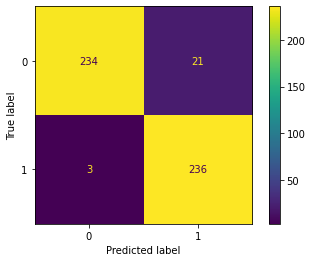

In [87]:
def plot_cm(model, x_test, y_test):
    y_pred_labels = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot();
    
plot_cm(pipe, X_test, y_test)

#### Save metrics and model

In [66]:
# save in a file the metrics computed on the reference set
now = datetime.now().strftime('%Y-%m-%d %H:%M')

dict_ref = [{
    "ts_date": now,
    "model_name": "lgb1",
    "algorithm": "lightgbm",
    "accuracy": acc,
    "roc_auc": roc_auc
}]

df_ref = pd.DataFrame(dict_ref)

# save initial file
df_ref.to_csv("model_metrics.csv", index=None)

#### Save model to the Model Catalog

In [77]:
# artifact_dir = tempfile.mkdtemp()
artifact_dir = "model_dir"

# with SklearnModel there is support for pipelines
sklearn_model = SklearnModel(estimator=pipe, artifact_dir= artifact_dir)

In [78]:
# this is the env for runtime, we're using a published conda env
CONDA_ENV = "oci://conda_envs@frqap2zhtzbe/conda_environments/cpu/mygeneralml_p37_cpu_/1.0/mygeneralml_p37_cpu_v1_0"

sklearn_model.prepare(
    inference_conda_env=CONDA_ENV,
    training_conda_env=CONDA_ENV,
    use_case_type=UseCaseType.BINARY_CLASSIFICATION,
    as_onnx=False,
    X_sample=X_test,
    y_sample=y_test,
    force_overwrite=True,
)

In [79]:
%load_ext autoreload
%autoreload 2

sklearn_model.verify(X_test.head(10))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Start loading model.joblib from model directory /home/datascience/workshop-july-2022/model_dir ...
Model is successfully loaded.


{'prediction': [1, 1, 0, 1, 0, 1, 1, 1, 0, 0]}

In [80]:
# compare with expected values
y_test[:10].values

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 0])

In [81]:
# add info on reference dataset used for training and on metrics in validation

ref_url = "oci://drift_input@frqap2zhtzbe/reference.csv"

sklearn_model.metadata_custom.add(key='reference dataset', value=ref_url, category=MetadataCustomCategory.TRAINING_AND_VALIDATION_DATASETS, 
                                  description='Reference dataset url. From this dataset have been extracted train/validation dataset', replace=True)

sklearn_model.metadata_custom.add(key='metrics on reference set', value=str(metrics), category=MetadataCustomCategory.PERFORMANCE, 
                                  description='Metrics evaluated on reference dataset', replace=True)

In [82]:
# check all custom metadata
sklearn_model.metadata_custom

data:
- category: Training Environment
  description: The conda environment where the model was trained.
  key: CondaEnvironment
  value: oci://conda_envs@frqap2zhtzbe/conda_environments/cpu/mygeneralml_p37_cpu_/1.0/mygeneralml_p37_cpu_v1_0
- category: Performance
  description: Metrics evaluated on reference dataset
  key: metrics on reference set
  value: '{''accuracy'': 0.9514, ''roc_auc'': 0.9939}'
- category: Training Environment
  description: The URI of the training conda environment.
  key: CondaEnvironmentPath
  value: oci://conda_envs@frqap2zhtzbe/conda_environments/cpu/mygeneralml_p37_cpu_/1.0/mygeneralml_p37_cpu_v1_0
- category: Training Environment
  description: The list of files located in artifacts folder.
  key: ModelArtifacts
  value: input_schema.json, test_json_output.json, model.joblib, runtime.yaml, score.py,
    output_schema.json
- category: Training Environment
  description: The slug name of the training conda environment.
  key: SlugName
  value: mygeneralml_

In [83]:
# save to the Model Catalog

MODEL_NAME = "employee-attr-lgbm-adstuner05"
model_id = sklearn_model.save(display_name=MODEL_NAME)

print(f"Model id in Model Catalog is {model_id}")

Start loading model.joblib from model directory /home/datascience/workshop-july-2022/model_dir ...
Model is successfully loaded.
['input_schema.json', 'test_json_output.json', 'model.joblib', 'runtime.yaml', 'score.py', 'output_schema.json']


loop1:   0%|          | 0/5 [00:00<?, ?it/s]

artifact:/tmp/saved_model_9a99f135-085d-44ca-b698-35777f0c3602.zip
Model id in Model Catalog is ocid1.datasciencemodel.oc1.eu-milan-1.amaaaaaangencdyayr37s6ihur3m7gb2mi2ujl5hfx57rkudm5bzjqy5kcja


### Deploy it as a REST service

In [84]:
sklearn_model.summary_status()

Actions Needed
Step      Status        Details                                                           
initiate  Done          Initiated the model                                               
prepare() Done          Generated runtime.yaml                                            
                        Generated score.py                                                
                        Serialized model                                                  
                        Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done          Local tested .predict from score.py                               
save()    Done          Conducted Introspect Test                                         
                        Uploaded artifact to model catalog                                
deploy()  Available     Deployed the model                                                
predict() Not Available Called deployment predict endpoint

In [85]:
LOG_GROUP_OCID = "ocid1.loggroup.oc1.eu-milan-1.amaaaaaangencdyagu7uraoiy44qxhvmhiacvmhgftlxbnhdcckigcp5yhxq"
ACCESS_LOG_OCID = "ocid1.log.oc1.eu-milan-1.amaaaaaangencdya4ex76jarx2ub5lodoxftqdomdcgpehtpa2tgqjz2nwpa"
PREDICT_LOG_OCID = "ocid1.log.oc1.eu-milan-1.amaaaaaangencdyaxuovu4gaomizq47qwsh3ofda3wtun5f7jjucncao4x3q"

sklearn_model.deploy(deployment_instance_shape="VM.Standard2.4",
                    display_name="employee-attr-lgbm-adstuner05-deploy2",
                    deployment_instance_count=1,
                    deployment_log_group_id=LOG_GROUP_OCID,
                    deployment_predict_log_id=PREDICT_LOG_OCID,
                    deployment_access_log_id=ACCESS_LOG_OCID)

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

In [86]:
sklearn_model.summary_status()

Actions Needed
Step      Status    Details                                                           
initiate  Done      Initiated the model                                               
prepare() Done      Generated runtime.yaml                                            
                    Generated score.py                                                
                    Serialized model                                                  
                    Populated metadata(Custom, Taxonomy and Provenance)               
verify()  Done      Local tested .predict from score.py                               
save()    Done      Conducted Introspect Test                                         
                    Uploaded artifact to model catalog                                
deploy()  ACTIVE    Deployed the model                                                
predict() Available Called deployment predict endpoint